In [61]:
import numpy as np
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import time
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pathlib import Path
import json
import threading
from obspy.taup import TauPyModel
from obspy.taup.taup_create import build_taup_model
import os
import multiprocessing as mp
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
import warnings
warnings.filterwarnings("ignore")

In [38]:
center = (-155.32, 19.39)
client = "IRIS"
minlongitude, maxlongitude, minlatitude, maxlatitude = (-155.55, -155.45, 19.52, 19.8)
network_list = ["HV", "PT"]
channel_list = "HH*,BH*,EH*,HN*"
starttime = obspy.UTCDateTime("2018-01-01T00")
endtime = obspy.UTCDateTime("2022-08-12T00")

config = {}
config["client"] = client
config["minlongitude"] = minlongitude
config["maxlongitude"] = maxlongitude
config["minlatitude"] = minlatitude
config["maxlatitude"] = maxlatitude
config["networks"] = network_list
config["channels"] = channel_list
config["starttime"] = starttime.datetime.isoformat(timespec="milliseconds")
config["endtime"] = endtime.datetime.isoformat(timespec="milliseconds")

In [39]:
input_path = Path("input")
output_path = Path("output")
if not output_path.exists():
    output_path.mkdir()

## Read Growclust catalog

In [40]:
catalog = pd.read_csv(input_path.joinpath("catalogs/out.growclust_cat"), sep="\s+", header=None, names=["yr", "mon", "day", "hr", "min", "sec", "evid", "latR", "lonR", "depR", "mag", "qID", "cID", "nbranch", "qnpair", "qndiffP", "qndiffS", "rmsP", "rmsS", "eh", "ez", "et", "latC", "lonC", "depC"])
catalog = catalog[catalog["nbranch"] > 1]

catalog["latitude"] = catalog["latR"]
catalog["longitude"] = catalog["lonR"]
catalog["depth_km"] = catalog["depR"]
catalog["time"] = catalog.apply(lambda x: datetime.fromisoformat(f"{x['yr']:04.0f}-{x['mon']:02.0f}-{x['day']:02.0f}T{x['hr']:02.0f}:{x['min']:02.0f}:{min(x['sec'],59.999):06.3f}"), axis=1)
catalog["timestamp"] = catalog.apply(lambda x: x.time.timestamp(), axis=1)
catalog_selected = catalog[
    (catalog["longitude"] > config["minlongitude"])
    & (catalog["longitude"] < config["maxlongitude"])
    & (catalog["latitude"] > config["minlatitude"])
    & (catalog["latitude"] < config["maxlatitude"])
]

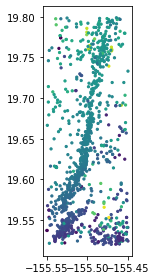

In [41]:
events = catalog_selected[["time", "latitude", "longitude", "depth_km"]]
plt.figure()
plt.scatter(events["longitude"], events["latitude"], c=events["depth_km"], s=5.0)
plt.axis("scaled")
plt.tight_layout()
plt.show()

## Sort events based on locations

In [42]:
def sort_events(events):
    
    X = []
    deg2km = 111.1949
    for index, event in events.iterrows():
        # X.append([(event["longitude"])*deg2km*np.cos(np.deg2rad( event["latitude"])), event["latitude"]*deg2km, event["depth_km"]])
        X.append([event["longitude"], event["latitude"]])
    X = np.array(X)

    Z = linkage(X, 'ward', optimal_ordering=True)
    leaves_index = leaves_list(Z)

    events_ = events.iloc[leaves_index].reset_index(drop=True) 
    
    return events_


In [43]:
events = sort_events(events)

## Download stations

In [44]:
def download_stations(config, station_json="stations.json", edge = 0.2):

    stations = Client(config["client"]).get_stations(
        network=",".join(config["networks"]),
        station="*",
        starttime=config["starttime"],
        endtime=config["endtime"],
        minlongitude=config["minlongitude"] - edge,
        maxlongitude=config["maxlongitude"] + edge,
        minlatitude=config["minlatitude"] - edge,
        maxlatitude=config["maxlatitude"] + edge,
        channel=config["channels"],
        level="response",
        # filename="stations.xml"
    )

    print("Number of stations: {}".format(sum([len(x) for x in stations])))
    # stations.plot('local', outfile="stations.png")
    #     stations.plot('local')

    ####### Save stations ########
    station_locs = defaultdict(dict)
    for network in stations:
        for station in network:
            for chn in station:
                sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
                if sid in station_locs:
                    if chn.code[-1] not in station_locs[sid]["component"]:
                        station_locs[sid]["component"].append(chn.code[-1])
                        station_locs[sid]["response"].append(round(chn.response.instrument_sensitivity.value, 2))
                else:
                    tmp_dict = {
                        "longitude": chn.longitude,
                        "latitude": chn.latitude,
                        "elevation(m)": chn.elevation,
                        "component": [
                            chn.code[-1],
                        ],
                        "response": [
                            round(chn.response.instrument_sensitivity.value, 2),
                        ],
                        "unit": chn.response.instrument_sensitivity.input_units.lower(),
                    }
                    station_locs[sid] = tmp_dict

    with open(station_json, "w") as fp:
        json.dump(station_locs, fp, indent=2)

    station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
    station_locs["id"] = station_locs.index
    return station_locs

Number of stations: 20


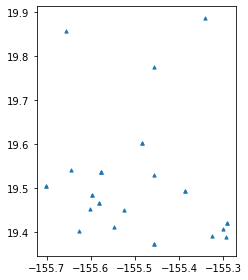

In [45]:
stations = download_stations(config, output_path/"stations.json", edge=0.16)

plt.figure()
plt.scatter(stations["longitude"], stations["latitude"], s=10, marker="^")
plt.axis("scaled")
plt.tight_layout()
plt.show()

## Download waveforms

In [47]:
def download_waveform(config, events, stations, window_length=30, data_path="output"):

    if isinstance(data_path, str):
        data_path = Path(data_path)
    waveform_dir = data_path / "waveforms"
    if not waveform_dir.exists():
        waveform_dir.mkdir(parents=True)

    ####### Download data ########
    client = Client(config["client"])

    def download(event):

        eventtime = obspy.UTCDateTime(event["time"])
        starttime = eventtime - 5
        endtime = eventtime + window_length - 5
        fname = "{}.mseed".format(starttime.datetime.isoformat(timespec="milliseconds"))

        if (waveform_dir/fname).exists():
            print(f"{fname} already exists.")
            return

        max_retry = 10
        stream = obspy.Stream()
        print(f"{fname} download starts")
        num_sta = 0

        for index, station in stations.iterrows():
        
            print(f"********{station['id']}********")
            network, station, location, channel = station["id"].split(".")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(
                        network,
                        station,
                        "*",
                        config["channels"],
                        starttime,
                        endtime,
                    )
                    #  for trace in tmp:
                    #      if trace.stats.sampling_rate != 100:
                    #          print(trace)
                    #          trace = trace.interpolate(100, method="linear")
                    #      trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
                    #      stream.append(trace)
                    stream += tmp
                    num_sta += len(tmp)
                    break

                except Exception as err:
                    print("Error {}.{}: {}".format(network, station, err))
                    message = "No data available for request."
                    if str(err)[: len(message)] == message:
                        break
                    retry += 1
                    time.sleep(5)
                    continue
                
            if retry == max_retry:
                print(f"{fname}: MAX {max_retry} retries reached : {network}.{station}")

        if len(stream) > 0:
            stream = stream.merge(fill_value="interpolate")
            stream = stream.trim(starttime+0.1, endtime-0.1, pad=True, fill_value=0)
            stream.write(waveform_dir / fname)
            print(f"{fname} download succeeds")

        else:
            print(f"{fname} empty data")

    threads = []
    MAX_THREADS = 8
    # MAX_THREADS = 1

    download(events.iloc[0])

    for index, event in events.iterrows():
        t = threading.Thread(target=download, args=(event,))
        t.start()
        # time.sleep(1)
        threads.append(t)
        if index % MAX_THREADS == MAX_THREADS - 1:
            for t in threads:
                t.join()
            threads = []
    for t in threads:
        t.join()

    return

In [48]:
download_waveform(config, events, stations, window_length=30, data_path=output_path)

2020-10-23T13:52:34.446.mseed already exists.
2020-10-23T13:52:34.446.mseed already exists.
2021-08-10T11:14:13.363.mseed already exists.
2019-09-18T03:48:14.674.mseed already exists.
2021-05-06T17:49:09.667.mseed already exists.
2021-05-21T20:22:33.103.mseed already exists.
2021-10-06T09:55:30.300.mseed already exists.
2019-10-25T00:22:10.402.mseed already exists.
2019-09-14T11:44:10.615.mseed already exists.
2021-05-21T04:07:43.005.mseed already exists.
2019-09-14T11:26:55.015.mseed already exists.
2021-08-05T09:05:19.123.mseed already exists.
2021-09-21T19:01:34.521.mseed already exists.
2019-08-04T15:35:39.959.mseed already exists.
2019-03-23T04:57:20.807.mseed already exists.
2021-02-02T23:43:39.444.mseed already exists.
2021-11-25T14:26:06.906.mseed already exists.
2019-08-01T00:02:48.539.mseed already exists.
2020-03-04T08:08:42.921.mseed already exists.
2020-08-24T09:36:56.003.mseed already exists.
2021-09-13T21:18:14.520.mseed already exists.
2020-03-17T05:44:53.628.mseed alre

## Plot waveforms

In [56]:
def traveltime(tvel_file, src_depth_km, dist_km, rec_depth_km=0, phases=["P", "p"], shift=0):

    try:
        model = TauPyModel(model=os.path.basename(tvel_file).split(".")[0])
    except:
        obspy.taup.taup_create.build_taup_model(tvel_file)
        model = TauPyModel(model=os.path.basename(tvel_file).split(".")[0])

    km2deg = 1.0 / 111.2

    if not isinstance(model, TauPyModel):
        model = TauPyModel(model=model)

    arrivals = model.get_travel_times(
        source_depth_in_km=src_depth_km + shift,
        distance_in_degree=dist_km * km2deg,
        receiver_depth_in_km=rec_depth_km + shift,
        phase_list=phases,
    )

    arr_times = []
    for arr in arrivals:
        # print(arr)
        arr_times.append(arr.time)
    
    if len(arr_times) == 0:
        return None
    return min(arr_times)

In [57]:
# vz_file = "ak135_debug.tvel"
# vz_file = "vz_hawaii2.tvel"
# config["taup_model"] = vz_file
# traveltime(str(input_path / vz_file), 16.524579427374235, -1.429, phases=["P","p"], shift=10)

In [51]:
def plot_waveforms(events, stations, window_length=30, data_path="waveforms", output_path="output"):

    vp, vs = 6.0, 6.0 / 1.73
    if isinstance(data_path, str):
        data_path = Path(data_path)
    if isinstance(output_path, str):
        output_path = Path(output_path)
    if not output_path.exists():
        output_path.mkdir(parents=True)

    normalize = lambda x: (x - x.mean()) / x.std()

    for i, event in events.iterrows():

        eventtime = obspy.UTCDateTime(event["time"])
        starttime = eventtime - 5
        endtime = eventtime + window_length
        fname = "{}.mseed".format(starttime.datetime.isoformat(timespec="milliseconds"))
        if not (data_path/fname).exists():
            print(f"{fname} does not exists.")
            continue

        stream = obspy.read(data_path / fname)
        stream = stream.filter("highpass", freq=1.0)
        stream = stream.trim(starttime + 1.0, endtime - 1.0, pad=True, fill_value=0)

        stations["dist_xy_km"] = stations.apply(
            lambda x: obspy.geodetics.base.gps2dist_azimuth(
                x["latitude"], x["longitude"], event["latitude"], event["longitude"]
            )[0]
            / 1000,
            axis=1,
        )
        stations["dist_xyz_km"] = stations.apply(
            lambda x: np.sqrt(x["dist_xy_km"] ** 2 + (x["elevation(m)"] / 1e3 - event["depth_km"]) ** 2), axis=1
        )
        stations = stations.sort_values(by="dist_xyz_km")

        fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={"width_ratios": [1, 8]})
        # axes[0].scatter(stations["longitude"], stations["latitude"], s=20, marker="^")
        axes[0].scatter(events["longitude"], events["latitude"], s=100, marker=".", color="k")
        axes[0].scatter(event["longitude"], event["latitude"], s=100, marker=".", color="red")

        ii = 0
        for j, station in stations.iterrows():
            network, station_, location, channel = station["id"].split(".")
            stream_selected = stream.select(network=network, station=station_, location=location, channel=channel + "Z")
            if len(stream_selected) > 0:
                for trace in stream_selected:
                    t = trace.times(reftime=eventtime)
                    axes[1].plot(t, normalize(trace.data) / 6 + ii, linewidth=0.7, color="k")
                    tp = traveltime(
                        str(input_path / config["taup_model"]),
                        event["depth_km"],
                        station["dist_xy_km"],
                        -station["elevation(m)"] / 1e3,
                        phases=["P", "p", "Pg"],
                        shift=10,
                    )
                    ts = traveltime(
                        str(input_path / config["taup_model"]),
                        event["depth_km"],
                        station["dist_xy_km"],
                        -station["elevation(m)"] / 1e3,
                        phases=["S", "s", "Sg"],
                        shift=10,
                    )
                    if tp is None:
                        tp = station["dist_xyz_km"] / vp
                    if ts is None:
                        ts = station["dist_xyz_km"] / vs
                    axes[1].plot([tp, tp], [ii - 0.7, ii + 0.7], color="blue")
                    axes[1].plot([ts, ts], [ii - 0.7, ii + 0.7], color="red")

                ii += 1
                
        plt.close(fig)
        fig.savefig(output_path / f"{i:04d}_{starttime.datetime.isoformat(timespec='milliseconds')}.png")
        print(f"Saving {i:04d}_{starttime.datetime.isoformat(timespec='milliseconds')}.png")

Saving 0000_2020-10-23T13:52:34.446.png
Saving 0001_2021-08-10T11:14:13.363.png
Saving 0002_2019-09-18T03:48:14.674.png
Saving 0003_2021-05-06T17:49:09.667.png
Saving 0004_2021-05-21T20:22:33.103.png
Saving 0005_2021-10-06T09:55:30.300.png
Saving 0006_2019-10-25T00:22:10.402.png
Saving 0007_2019-09-14T11:44:10.615.png
Saving 0008_2019-09-14T11:26:55.015.png
Saving 0009_2021-05-21T04:07:43.005.png
Saving 0010_2021-08-05T09:05:19.123.png
Saving 0011_2019-03-23T04:57:20.807.png
Saving 0012_2021-09-21T19:01:34.521.png
Saving 0013_2019-08-04T15:35:39.959.png
Saving 0014_2021-02-02T23:43:39.444.png
Saving 0015_2021-11-25T14:26:06.906.png
Saving 0016_2019-08-01T00:02:48.539.png
Saving 0017_2020-03-04T08:08:42.921.png
Saving 0018_2020-08-24T09:36:56.003.png
Saving 0019_2021-09-13T21:18:14.520.png
Saving 0020_2020-03-17T05:44:53.628.png
Saving 0021_2021-05-21T17:12:07.154.png
Saving 0022_2021-09-12T01:39:01.701.png
Saving 0023_2021-06-28T15:16:59.753.png
Saving 0024_2021-09-12T02:38:06.207.png


ValueError: min() arg is an empty sequence

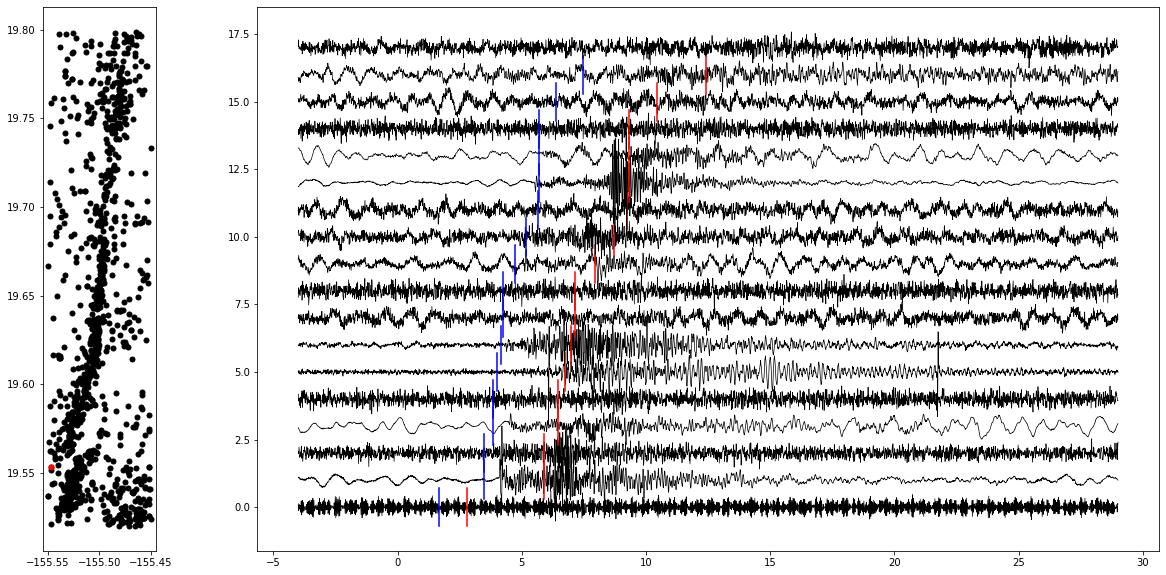

In [53]:
# plot_waveforms(events, stations, 30, output_path/"waveforms", output_path/"figures")

In [65]:
if __name__ == "__main__":
    ctx = mp.get_context('spawn')
    ncpu = mp.cpu_count()
    print("Number of CPUs: {}".format(ncpu))
    processes = []
    for i in range(ncpu):
        p = ctx.Process(target=plot_waveforms, args=(events.iloc[i::ncpu], stations, 30, output_path/"waveforms", output_path/"figures"))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()


Number of CPUs: 16


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/weiqiang/.local/miniconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/weiqiang/.local/miniconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'plot_waveforms' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/weiqiang/.local/miniconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/weiqiang/.local/miniconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'plot_waveforms' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/

In [26]:
def plot_waveforms(events, stations, window_length=30, data_path = "waveforms", output_path="output"):
    
    vp, vs = 6.0, 6.0/1.73
    if isinstance(data_path, str):
        data_path = Path(data_path) 
    if isinstance(output_path, str):
        output_path = Path(output_path)
    if not output_path.exists():
        output_path.mkdir(parents=True)

    normalize = lambda x: (x - x.mean()) / x.std()
        
    for i, event in events.iterrows():
        
        eventtime = obspy.UTCDateTime(event["time"])
        starttime = eventtime - 5
        endtime = eventtime + window_length
        fname = "{}.mseed".format((starttime.datetime.isoformat(timespec="milliseconds")))

        if not (data_path/fname).exists():
            print(f"{fname} does not exists.")
            continue

        stream = obspy.read(data_path / fname)
        stream = stream.filter("highpass", freq = 1.0)
        stream = stream.trim(starttime+1.0, endtime-1.0, pad=True, fill_value=0)

        stations["dist_km"] = stations.apply(lambda x: obspy.geodetics.base.gps2dist_azimuth(x["latitude"], x["longitude"], event["latitude"], event["longitude"])[0]/1000, axis=1)
        stations["dist_km"] = stations.apply(lambda x: np.sqrt(x["dist_km"]**2 + (x["elevation(m)"]/1e3 - event["depth_km"])**2), axis=1)
        stations = stations.sort_values(by="dist_km")

        fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 8]})
        # axes[0].scatter(stations["longitude"], stations["latitude"], s=20, marker="^")
        axes[0].scatter(events["longitude"], events["latitude"], s=100, marker=".", color="k")
        axes[0].scatter(event["longitude"], event["latitude"], s=100, marker=".", color="red")

        ii = 0
        for j, station in stations.iterrows():
            network, station_, location, channel = station["id"].split(".")
            stream_selected = stream.select(network=network, station=station_, location=location, channel=channel+"Z")
            
            if len(stream_selected) > 0:
                for trace in stream_selected:
                    t = trace.times(reftime=eventtime)
                    axes[1].plot(t, normalize(trace.data) / 6 + ii, linewidth=0.7)
                    tp = traveltime(str(input_path / config["taup_model"]), event["depth_km"], station["dist_km"], -station["elevation(m)"]/1e3, phases=["P","p"], shift=10)
                    ts = traveltime(str(input_path / config["taup_model"]), event["depth_km"], station["dist_km"], -station["elevation(m)"]/1e3, phases=["S","s"], shift=10)
                    axes[1].plot([station["dist_km"]/vp, station["dist_km"]/vp], [ii-0.7, ii+0.7], color="blue")
                    axes[1].plot([station["dist_km"]/vs, station["dist_km"]/vs], [ii-0.7, ii+0.7], color="red")
                ii += 1
        plt.close(fig)
        fig.savefig(output_path / f"{i:04d}_{eventtime.datetime.isoformat(timespec='milliseconds')}.png")
        print(f"Saving {i:04d}_{eventtime.datetime.isoformat(timespec='milliseconds')}.png")

        # raise

Saving 0000_2020-03-03T11:40:04.271.png
Saving 0001_2021-06-07T12:08:45.153.png
Saving 0002_2021-11-24T12:17:36.927.png
Saving 0003_2020-07-20T09:17:26.676.png
Saving 0004_2018-11-15T03:41:28.864.png
Saving 0005_2018-12-02T18:14:02.530.png
Saving 0006_2020-12-10T02:01:20.717.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0007_2021-01-15T00:03:07.418.png
Saving 0008_2019-02-03T07:47:53.595.png
Saving 0009_2021-04-17T04:39:52.031.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0010_2019-09-18T03:48:19.674.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0011_2020-10-23T13:52:39.446.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0012_2021-08-10T11:14:18.363.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0013_2021-02-02T23:43:44.444.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0014_2019-08-04T15:35:44.959.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0015_2019-03-23T04:57:25.807.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0016_2019-06-05T20:27:02.347.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0017_2021-07-27T21:58:10.652.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0018_2021-07-27T12:52:33.127.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0019_2020-03-17T05:44:58.628.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0020_2020-03-04T08:08:47.921.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0021_2019-02-02T04:31:17.383.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0022_2019-02-10T20:43:35.702.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0023_2019-07-01T14:36:08.199.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0024_2021-05-24T16:21:58.928.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0025_2021-09-12T14:27:56.094.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0026_2021-05-23T16:49:41.869.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0027_2021-06-10T14:05:01.118.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0028_2021-09-12T01:39:06.701.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0029_2021-09-12T02:38:11.207.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0030_2021-09-11T20:20:49.190.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0031_2021-09-11T18:49:12.622.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0032_2021-09-11T16:33:00.505.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0033_2021-09-11T17:10:24.878.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0034_2021-09-11T18:55:28.031.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0035_2021-09-12T12:39:22.311.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0036_2021-10-02T01:29:31.827.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0037_2021-09-12T04:54:12.184.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0038_2021-09-12T04:47:39.600.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0039_2021-01-10T08:00:24.531.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0040_2021-09-12T03:19:03.675.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

Saving 0041_2021-09-11T19:10:11.450.png


/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow((radius_of_planet - top_depth), b)
/home/weiqiang/.local/miniconda3/lib/python3.9/site-packages/obspy/taup/slowness_layer.py:284: RuntimeWarning: overflow encountered in double_scalars
  a_denominator = pow(

KeyboardInterrupt: 

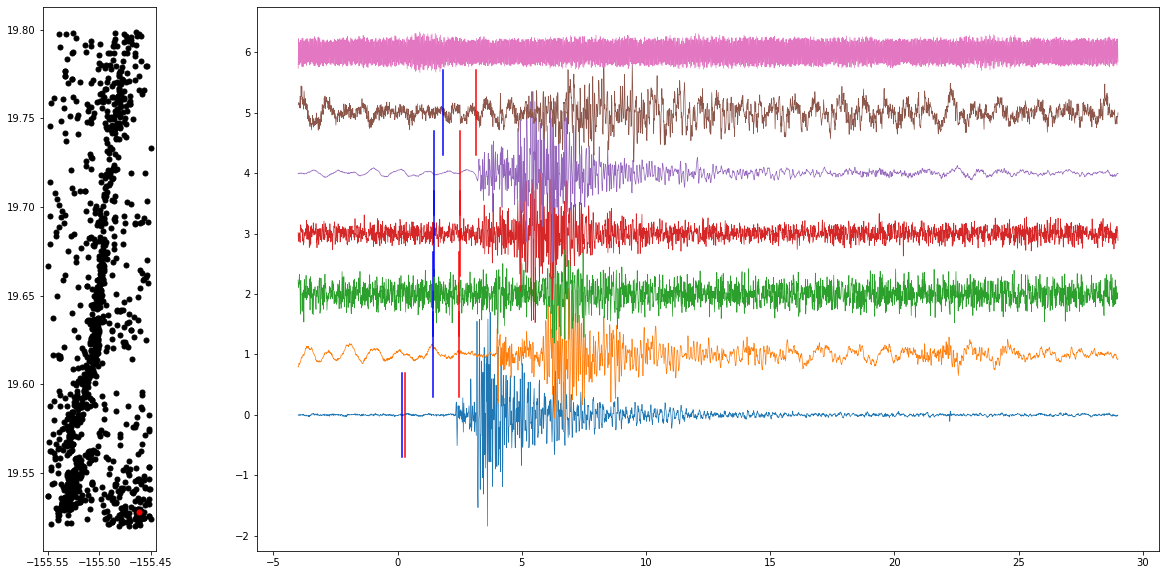

In [28]:
plot_waveforms(events, stations, 30, output_path/"waveforms", output_path/"figures")

In [ ]:
station_locs = defaultdict(dict)
for network in stations:
    for station in network:
        for chn in station:
            if station.code in exclude_stations:
                continue
            sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
            if sid in station_locs:
                station_locs[sid]["component"] += f",{chn.code[-1]}"
                station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
            else:
                component = f"{chn.code[-1]}"
                response = f"{chn.response.instrument_sensitivity.value:.2f}"
                dtype = chn.response.instrument_sensitivity.input_units.lower()
                tmp_dict = {}
                tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = (
                    chn.longitude,
                    chn.latitude,
                    chn.elevation,
                )
                tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                station_locs[sid] = tmp_dict

station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
# station_locs.to_csv(
#     "station.csv",
#     sep="\t",
#     float_format="%.3f",
#     index_label="station",
#     columns=["longitude", "latitude", "elevation(m)", "unit", "component", "response"],
# )
station_locs

In [ ]:
events = [
["2019-07-08T00:00:02.602",	0.842,	-117.520, 35.666, 16099.143, 0.309, 0.348, 0.009],
["2019-07-08T00:00:36.266",	0.732,	-117.655, 35.928, 9.582, 1.087, 0.309, -0.115],
["2019-07-08T00:01:57.554",	1.171,	-117.929, 36.208, 0.000, 2.056, 0.403, -0.043],
# ["2019-07-08T00:03:01.799", 0.897,	-117.648, 36.017, 14623.906, 2.912, 0.515, 0.037],
# ["2019-07-08T00:03:11.713", 0.831,	-117.824, 35.997, 7947.798,  1.603, 0.229, 0.061],
["2019-07-08T00:03:20.519", 1.063,	-117.689, 35.934, 12833.157, 0.608, 0.189, 0.002],
["2019-07-08T00:03:29.390", 0.438,	-117.744, 35.884, 767.469,   1.937, 0.461, 0.051],
["2019-07-08T00:03:36.456", 1.275,	-117.809, 36.080, 9876.259,  2.142, 0.213, 0.011],
["2019-07-08T00:04:13.122",	0.657,	-117.933, 36.214, 0.000,  1.039, 0.540, -0.017],
["2019-07-08T00:04:42.992",	1.024,	-117.789, 36.132, 9983.541, 1.088, 0.311, 0.084],
["2019-07-08T00:05:26.130", 0.113,	-117.830, 36.087, 1075.595, 0.504, 0.364, 0.025]
]

# ["2019-07-08T00:03:49.841", 1.017,	-117.835, 36.039, 5193.985,  0.714, 0.177, 0.016]]
# events = [
# ["2019-07-08T00:03:01.799", 0.897,	-117.59751,	35.81574, 14623.906, 2.912, 0.515, 0.037],
# ["2019-07-08T00:03:11.713", 0.831,	-117.824, 35.997, 7947.798,  1.603, 0.229, 0.061],
# ["2019-07-08T00:03:20.519", 1.063,	-117.689, 35.934, 12833.157, 0.608, 0.189, 0.002],
# ["2019-07-08T00:03:29.390", 0.438,	-117.744, 35.884, 767.469,   1.937, 0.461, 0.051],
# ["2019-07-08T00:03:36.456", 1.275,	-117.809, 36.080, 9876.259,  2.142, 0.213, 0.011],
# ["2019-07-08T00:03:49.841", 1.017,	-117.835, 36.039, 5193.985,  0.714, 0.177, 0.016]]

In [ ]:
def plot_stream(stream, station_locs, event):
    event_lng, event_lat = event[2], event[3]
    dists = []
    vecs = []
    ids = []
    nt = len(stream[0].data) - 1
    for trace in stream:
        sta_lng, sta_lat = station_locs.loc[trace.id[:-1]]["longitude"], station_locs.loc[trace.id[:-1]]["latitude"]
        dist = np.sqrt((event_lng - sta_lng)**2 + (event_lat - sta_lat)**2) * degree2km
        # print(dist)
        dists.append(dist)
        vecs.append(trace.data[:nt])
        vecs.append(trace.data)
        ids.append(trace.id)
    vecs = np.array(vecs)
    dists = np.array(dists)

    vecs = vecs/np.std(vecs)
    
    normalize = lambda x: (x - np.mean(x)) / np.std(x)
    # plt.figure(figsize=(10, 10))
    plt.figure()
    for i, idx in enumerate(np.argsort(dists)):
        t = [datetime.fromisoformat(event[0]) + timedelta(seconds=x) for x in np.arange(0, len(vecs[idx])) / trace.stats.sampling_rate]
        # plt.plot(normalize(vecs[idx]) + dists[idx], 'k', linewidth=1.0)
        # plt.plot(t, normalize(vecs[idx])/7 + i , 'k', linewidth=0.5, rasterized=True)
        plt.plot(t, vecs[idx]/7 + i , 'k', linewidth=0.5, rasterized=True)
        # plt.text(t[0], i-0.5, ids[idx], color="b")
        # plt.plot(vecs[idx]*1e7 + dists[idx] , 'k', linewidth=1.0)
        # if i > 8:
        #     break
    # plt.ylim([0, 50])
    # plt.ylim([-0.9, 10])
    plt.gca().autoscale(enable=True, axis='x', tight=True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    plt.gcf().autofmt_xdate()
    plt.ylabel("Station index by distance")
    plt.xlabel("Time from 2019-07-08T00")
    print(event)
    plt.title(f'M = {event[1]:.1f}, '+ r'$\Sigma_{11}$ = ' + f"{event[5]:.1f}" + r' s$^2$' + ', ' +  r'$\Sigma_{22}$ = ' + f"{event[6]:.1f}" + r' ($\log_{10}$ m/s)$^2$')
    plt.savefig(f"figures/new_events/{event[0]}.png", dpi=300)
    plt.savefig(f"figures/new_events/{event[0]}.pdf", dpi=300)
    plt.show()
# plot_stream(stream, station_locs, events[-1])

In [ ]:
interval = 9 
client = Client(config["client"])
for event in events:
    starttime = obspy.UTCDateTime(event[0]) + event[4]/1000/7
    endtime = starttime + interval
    fname = "{}.mseed".format(starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S"))
    
    max_retry = 10
    stream = obspy.Stream()
    print(f"{fname} download starts")
    num_sta = 0
    for network in stations:
        for station in network:
            if station.code in exclude_stations:
                continue
            print(f"********{network.code}.{station.code}********")
            retry = 0
            while retry < max_retry:
                try:
                    tmp = client.get_waveforms(
                        network.code, station.code, "*", config["channels"], starttime, endtime,  attach_response=True
                    )
                    #  for trace in tmp:
                    #      if trace.stats.sampling_rate != 100:
                    #          print(trace)
                    #          trace = trace.interpolate(100, method="linear")
                    #      trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
                    #      stream.append(trace)
                    stream += tmp
                    num_sta += len(tmp)
                    break
                except Exception as err:
                    print("Error {}.{}: {}".format(network.code, station.code, err))
                    message = "No data available for request."
                    if str(err)[: len(message)] == message:
                        break
                    retry += 1
                    time.sleep(5)
                    continue
            if retry == max_retry:
                print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code}")
    stream = stream.merge()
    stream = stream.remove_sensitivity()
    stream = stream.detrend("spline", order=2, dspline=1*stream[0].stats.sampling_rate)
    # stream = stream.filter("highpass", freq=1.0)
    # stream.plot()
    plot_stream(stream, station_locs, event)
    plt.show()
    # break


In [ ]:
station_id = ["CLC", "CCC", "LRL", "SRT", "SLA", "TOW2", "WRC2", "WBM", "MPM", "WNM", "WVP2", "JRC2", "WCS2", "DTP", "WRV2", "WMF"]
network_id = ["CI"]
# channels = ["HHE","HHN","HHZ"]
channels = ["HHZ"]
## M6.4
# start_time = obspy.UTCDateTime("2019-07-04T17:33:49") - 60
# end_time = start_time + 120 
## M7.1
# start_time = obspy.UTCDateTime("2019-07-06T03:19:53") - 60
# end_time = start_time + 120
# start_time = obspy.UTCDateTime("2020-06-04T01:32:11") - 60
# end_time = start_time + 120 
# start_time = obspy.UTCDateTime("2020-06-24T17:40:49") - 60
start_time = obspy.UTCDateTime("2019-07-08T00:03:00") 
end_time = start_time + 80 

In [ ]:
stream = client.get_waveforms(",".join(network_id), ",".join(station_id), "*", ",".join(channels), start_time, end_time, attach_response=True)
stream = stream.merge()
stream = stream.trim(start_time, end_time, fill_value=0)
stream = stream.sort()
stream = stream.remove_sensitivity()


In [ ]:
events

In [ ]:
# stream_bak = stream.copy()
stream = stream_bak.copy()
stream = stream.detrend("linear")
stream = stream.filter("bandpass", freqmin=0.5, freqmax=50, corners=2, zerophase=True)

In [ ]:
vec = []
amp = []
for sta in station_id:
    vec_sta = []
    for chn in channels:
        if len(stream.select(station=sta, channel=chn)) == 0:
            print(sta, chn)
        else:
            trace = stream.select(station=sta, channel=chn)[0]
        vec_sta.append(trace.data)
    vec.append(vec_sta)
    # amp.append(np.max(np.abs(vec_sta)))
    amp.append(np.std(vec_sta))
vec = np.array(vec)
amp = np.array(amp)
print(vec.shape) # nsta, nchn, npts

In [ ]:
plt.figure(figsize=(10,5))
idx = np.argsort(amp)
for ii, i in enumerate(idx[::-1]):
    plt.plot((vec[i, 0, :] - np.mean(vec[i, 0, :]))/amp[i]/10 + ii, 'k', linewidth=0.5)
plt.show()

In [ ]:
stream.select(channel="*Z").plot()